# 1.상장법인 코드 추출하기(yahoo finance)

In [1]:
# 코스닥, 코스피 종목코드 yf에서 추출
import pandas as pd
import FinanceDataReader as fdr

In [2]:
stocks = fdr.StockListing('KRX')

In [3]:
stocks

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도
...,...,...,...,...,...,...,...,...,...,...
8243,003280,KOSPI,흥아해운,해상 운송업,외항화물운송업(케미컬탱커),1976-06-29,12월,이환구,http://www.heung-a.com,서울특별시
8244,037440,KOSDAQ,희림,"건축기술, 엔지니어링 및 관련 기술 서비스업",설계 및 감리용역,2000-02-03,12월,"정영균, 이목운, 허철호 (각자대표)",http://www.heerim.com,서울특별시
8245,419890,KOSPI,히어로즈 단기채권ESG액티브,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8246,429870,KOSPI,히어로즈 리츠이지스액티브,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [4]:
stockcode = stocks[['Symbol', 'Market', 'Name']]

In [5]:
stockcode.head()

,Symbol,Market,Name
0,060310,KOSDAQ,3S
1,095570,KOSPI,AJ네트웍스
2,006840,KOSPI,AK홀딩스
3,054620,KOSDAQ,APS홀딩스
4,265520,KOSDAQ,AP시스템


In [6]:
# 해당하는 종목코드 추출
def code(stock):
    a = stockcode[stockcode['Name'] == stock]
    a_code = a['Symbol'].item()
    a_market = a['Market'].item()
    if a_market == 'KOSPI':
        a_market = '.KS'
    elif a_market == 'KOSDAQ':
        a_market = '.KQ'
    return a_code + a_market
    

In [7]:
code('삼성전자')[:6]

'005930'

# 2. 야후파이낸스에서 원하는 종목 수익률과 한달치 일별 수익률 변동 확인

In [8]:
import yfinance as yf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib as plt

In [9]:
# 날짜: 자동으로 설정
# 티커: 함수이용

# 어제 수익률 보기
def yesterday_rtn(name):
    a = code(name)
    today = date.today()
    weekago = date.today() - relativedelta(weeks=1)
 
    df = yf.download(a, start=str(weekago), end=str(today), progess=False)
    df['daily_rtn'] = df['Adj Close'].pct_change()
    last_rtn = df['daily_rtn'][-1:].item()
    return last_rtn

# 한달동안 일별 수익률 추이 보기
def monthly_rtn_graph(name):
    a = code(name)
    today = date.today()
    monthago = date.today() - relativedelta(months=1)

    df = yf.download(a, start=str(monthago), end=str(today), progess=False)
    df['daily_rtn'] = df['Adj Close'].pct_change()

    return df['daily_rtn'].plot()

In [10]:
yesterday_rtn('삼성전자')

[*********************100%***********************]  1 of 1 completed


0.0014992503748125774

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

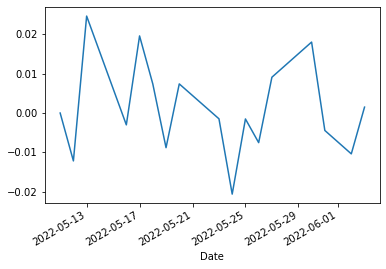

In [11]:
monthly_rtn_graph('삼성전자')

# 3. 한경컨센서스


In [12]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import FinanceDataReader as fdr
import re
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np

In [13]:
today = date.today()
monthago = date.today() - relativedelta(months=1)

In [14]:
# stocks = fdr.StockListing('KRX') # 코스피, 코스닥, 코넥스 전체

In [15]:
stocks['Symbol'] = stocks['Symbol'].astype(str)
def remove_noise_and_split_title(title):
    in_code = ''
    in_name = ''
    
    for code, name in stocks[['Symbol', 'Name']].values:
        if code in title and name in title:
            in_code = code
            in_name = name
    
    # 한글, 영어, 숫자 외 노이즈 제거
    clean_title = re.sub('[^A-Za-z0-9가-힣]', ' ', title)
    
    # 기업명 코드 수정
    clean_title = clean_title.replace(in_code, ' ')
    clean_title = clean_title.replace(in_name, ' ')
    while ' ' * 2 in clean_title:
        clean_title = clean_title.replace(' ' * 2, ' ')
    
    if in_name == '': # 기업명이 없는 제목이라면, 데이터에 추가하지 않음
        return [None] 
    else:
        return [in_name, in_code, clean_title]  

In [16]:
# "http://consensus.hankyung.com/apps.analysis/analysis.list?&sdate=2016-09-01&edate=2021-08-31&report_type=CO&order_type=&now_page={}"
base_url = "http://hkconsensus.hankyung.com/apps.analysis/analysis.list?&sdate=%s&edate=%s&report_type=CO&order_type=&now_page={}"%(monthago, today) #오늘부터 한달전꺼 까지
data = [] 

for page_no in range(1,37):
    while True:
        try:
            url = base_url.format(page_no)
            html = requests.get(url, headers={'User-Agent':'Gils'}).content
            soup = BeautifulSoup(html, 'lxml')
            print("{}/{}".format(page_no, '37'))
            break
        except:
            time.sleep(15 * 60)

    table = soup.find("div", {"class":"table_style01"}).find('table')
    for tr in table.find_all("tr")[1:]: # 1번째 행부터 순회
        record = []
        for i, td in enumerate(tr.find_all("td")[:6]): # 6번째 셀까지 순회
            if i == 1:
                record += remove_noise_and_split_title(td.text) # remove_noise_title의 출력과 이어 붙임
            elif i == 3: # 노이즈가 껴있는 세번째 셀만 따로 처리
                record.append(td.text.replace(" ", "").replace("\r","").replace("\n",""))
            else: # 1번째 셀이 아니면:
                record.append(td.text) # 셀의 텍스트 값 그대로 입력
            
        if None not in record: # 레코드에 None이 없으면
            data.append(record)

    time.sleep(1) # 연결 끊김 방지를 위해, 1초씩 재움
    
data = pd.DataFrame(data, columns = ["작성일", "종목명", "종목코드", "제목", "적정가격", "평가의견", "작성자", "작성기관"])
data.to_csv("리포트_데이터.csv", index = False, encoding = "cp949")

1/37
2/37
3/37
4/37
5/37
6/37
7/37
8/37
9/37
10/37
11/37
12/37
13/37
14/37
15/37
16/37
17/37
18/37
19/37
20/37
21/37
22/37
23/37
24/37
25/37
26/37
27/37
28/37
29/37
30/37
31/37
32/37
33/37
34/37
35/37
36/37


In [17]:
def buy_sell(name):
    buyorsell = data[data['종목코드'] == code(name)[:6]]['평가의견']
    buyorsell[:1]

In [18]:
data.tail()

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관
633,2022-05-09,기업은행,024110,꾸준한 실적개선 높은 배당수익률 꾸준한 실적개선 높은 배당수익률 대규모 비용발생에...,"15,000",Buy,김은갑,IBK투자증권
634,2022-05-09,우리금융지주,316140,이익창출력 크게 향상 이익창출력 크게 향상 NIM 상승 이익규모 크게 증가 중,"21,000",Buy,김은갑,IBK투자증권
635,2022-05-09,하나금융지주,086790,매력적인 Valuation 높은 배당매력 매력적인 Valuation 높은 배당매력...,"66,000",Buy,김은갑,IBK투자증권
636,2022-05-09,신한지주,055550,꾸준한 실적과 앞서가는 자본정책 꾸준한 실적과 앞서가는 자본정책 대규모 비용요인에...,"55,000",Buy,김은갑,IBK투자증권
637,2022-05-09,KB금융,105560,안정적 사업구조 이익증가세 지속 안정적 사업구조 이익증가세 지속 이어가는 사상 최...,"78,000",Buy,김은갑,IBK투자증권


In [19]:
def monthly_opinion(name):
    buyorsell = data[data['종목코드'] == code(name)[:6]]
    buyorsell = buyorsell[['작성일','작성기관','평가의견']]
    return buyorsell

In [20]:
# buyorsell_recent[:, np.newaxis]

In [21]:
# 1차 완성
def mystock(name):
    print(yesterday_rtn(name))
    print(monthly_opinion(name))

In [22]:
mystock('OCI')

[*********************100%***********************]  1 of 1 completed
0.03937007874015741
            작성일    작성기관 평가의견
43   2022-06-02  유진투자증권  Buy
116  2022-05-31   메리츠증권  Buy


# 4. 종토방 댓글 내용 / 갯수 count 하기

In [23]:

# url = "https://finance.naver.com/item/board.naver?code=%s&page=1"%code('삼성전자')[:6]

# headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0' }

# resp = requests.get(url, headers=headers)

# soup = BeautifulSoup(resp.text, "html.parser")

# reply_date = soup.find_all('span', {'class':'tah p10 gray03'})

In [24]:
code('OCI')

'010060.KS'

In [25]:
base_url_2 = "https://finance.naver.com/item/board.naver?code=%s&page={}"%(code(name))

def naver_crawling(name):
    b = []
    
    for i in range(1001):
        url = base_url_2.format(i)
        headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0' }

        resp = requests.get(url, headers=headers)
        soup = BeautifulSoup(resp.text, "html.parser")
        reply_date = soup.find_all('span', {'class':'tah p10 gray03'})
        
        for i in reply_date:
            b.append(i.string)
    return b
# find('reply_date')['tah p10 gray03']

SyntaxError: invalid syntax (38600235.py, line 1)

In [ ]:
naver_crawling(100)

KeyboardInterrupt: 

In [ ]:
samsung[-5:]

['529', '2022.05.21 01:13', '501', '2022.05.21 01:11', '605']

In [ ]:
# 어제,아레 만들어서 형식 고치기
ytd = str(date.today() - relativedelta(days=1))
true_ytd = ytd[:4] + '.' + ytd[5:7] + '.' + ytd[8:10]

twodaysago = str(date.today() - relativedelta(days=2))
twodaysago = twodaysago[:4] + '.' + twodaysago[5:7] + '.' + twodaysago[8:10]


'2022.06.03'

In [ ]:
# 댓글 갯수 예시
temp_minus_1=[]
temp_minus_2=[]

for i in range(len(samsung)):
    if samsung[i][:10] == true_ytd:
        temp_minus_1.append(samsung[i])
    elif samsung[i][:10] == twodaysago:
        temp_minus_2.append(samsung[i])
    else:
        pass
    
reply_vol =((len(temp_minus_1) - len(temp_minus_2)) / len(temp_minus_2)) # 아레 대비 어제 댓글 수 변화
reply_vol

-0.26045883940620784

In [ ]:
# 2차 완성..을 못했어요....힘드러요.....미안해요....능력부족이에요...
def mystock(name):
    print(yesterday_rtn(name))
    print(monthly_opinion(name))
    # print(reply_volatility(name))

1096

# 5. 정리

In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import yfinance as yf
from datetime import date, timedelta
import matplotlib as plt
import requests
from bs4 import BeautifulSoup
import time
import re
from dateutil.relativedelta import relativedelta

In [2]:
#함수들 모음

# 날짜: 자동으로 설정
# 티커: 함수이용

# 해당하는 종목코드 추출


def code(name):

    stocks = fdr.StockListing('KRX')
    stockcode = stocks[['Symbol', 'Market', 'Name']]
    
    a = stockcode[stockcode['Name'] == name]
    a_code = a['Symbol'].item()
    a_market = a['Market'].item()
    
    if a_market == 'KOSPI':
        a_market = '.KS'
    
    elif a_market == 'KOSDAQ':
        a_market = '.KQ'
    
    return a_code + a_market
    
# 어제 수익률 보기
def yesterday_rtn(name):

    b = code(name)

    today = date.today()
    weekago = date.today() - relativedelta(weeks=1)
 
    df = yf.download(b, start=str(weekago), end=str(today), progess=False)
    
    df['daily_rtn'] = df['Adj Close'].pct_change()
    last_rtn = df['daily_rtn'][-1:].item()
    
    return last_rtn

# 한달동안 일별 수익률 추이 보기
def monthly_rtn_graph(name):
    
    b = code(name)
    
    today = date.today()
    monthago = date.today() - relativedelta(months=1)

    df = yf.download(b, start=str(monthago), end=str(today), progess=False)
    df['daily_rtn'] = df['Adj Close'].pct_change()

    return df['daily_rtn'].plot()




In [3]:
today = date.today()
monthago = date.today() - relativedelta(months=1)

# 한경컨센서스 전처리작업
stocks = fdr.StockListing('KRX')
stocks['Symbol'] = stocks['Symbol'].astype(str)

def remove_noise_and_split_title(title):

    in_code = ''
    in_name = ''
    
    for code, name in stocks[['Symbol', 'Name']].values:

        if code in title and name in title:

            in_code = code
            in_name = name
    
    # 한글, 영어, 숫자 외 노이즈 제거
    clean_title = re.sub('[^A-Za-z0-9가-힣]', ' ', title)
    
    # 기업명 코드 수정
    clean_title = clean_title.replace(in_code, ' ')
    clean_title = clean_title.replace(in_name, ' ')

    while ' ' * 2 in clean_title:

        clean_title = clean_title.replace(' ' * 2, ' ')
    
    if in_name == '': # 기업명이 없는 제목이라면, 데이터에 추가하지 않음
        return [None] 

    else:
        return [in_name, in_code, clean_title]  
  
# 한경컨센서스 투자의견 불러오기
# 한달치만 투자의견 불러오게 설정, 만약 바꾸려변 base_url과 for문의 range 범위 재설정
# for문의 range는 한달치가 대부분 35페이지를 넘지 않기 때문에, 40개로 임의로 설정함.
def opinion(name):

    base_url = "http://hkconsensus.hankyung.com/apps.analysis/analysis.list?&sdate=%s&edate=%s&report_type=CO&order_type=&now_page={}"%(monthago, today) #오늘부터 한달전꺼 까지
    data = [] 

    for page_no in range(1,41): 

        while True:
            try:
                url = base_url.format(page_no)
                html = requests.get(url, headers={'User-Agent':'Gils'}).content
                soup = BeautifulSoup(html, 'lxml')
                print("{}/{}".format(page_no, '40'))
                break

            except:
                time.sleep(15 * 60)

        table = soup.find("div", {"class":"table_style01"}).find('table')

        for tr in table.find_all("tr")[1:]: # 1번째 행부터 순회
            record = []

            for i, td in enumerate(tr.find_all("td")[:6]): # 6번째 셀까지 순회

                if i == 1:
                    record += remove_noise_and_split_title(td.text) # remove_noise_title의 출력과 이어 붙임

                elif i == 3: # 노이즈가 껴있는 세번째 셀만 따로 처리
                    record.append(td.text.replace(" ", "").replace("\r","").replace("\n",""))

                else: # 1번째 셀이 아니면:
                    record.append(td.text) # 셀의 텍스트 값 그대로 입력
                
            if None not in record: # 레코드에 None이 없으면
                data.append(record)

        time.sleep(1) # 연결 끊김 방지를 위해, 1초씩 재움
        
    data = pd.DataFrame(data, columns = ["작성일", "종목명", "종목코드", "제목", "적정가격", "평가의견", "작성자", "작성기관"])
    data.to_csv("리포트_데이터.csv", index = False, encoding = "cp949")
    # data[data['종목코드'] == code(name)[:6]]['평가의견']
    data = data[data['종목코드'] == code(name)[:6]]
    data = data
    return data

In [4]:
opinion('삼성전자')

1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
40/40


,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관
136,2022-05-31,삼성전자,005930,실적 모멘텀 이후 주주가치 증대는 필연적 실적 모멘텀 이후 주주가치 증대는 필연적...,"84,000",Buy,김선우,메리츠증권
199,2022-05-30,삼성전자,005930,현주가 수준은 저점 매수가 가능한 가격대 현주가 수준은 저점 매수가 가능한 가격대...,"82,000",Buy,송명섭,하이투자증권
245,2022-05-26,삼성전자,005930,2H22 수요가 관건 2H22 수요가 관건 자율주행과 파운드리 2H22 수요가 관건,"87,000",Buy,"남대종, 김광수",이베스트증권


In [36]:
# 원하는 주식종목 네이버 종토방 댓글 크롤링하여 2일전 대비 1일전의 변동치 측정하기

# 원하는 종목 네이버 종토방 댓글 갯수(어제것만)
def naver_crawling(name):

    b = []
    base_url_2 = "https://finance.naver.com/item/board.naver?code=%s&page={}"%(code(name)[:6])
    
    for i in range(10): #삼성전자 기준 1000개정도 해야 하루치 넘는 댓글 가져올 수 있으므로 하한 1000으로 지정함
    
        url = base_url_2.format(i)
        headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0' }

        resp = requests.get(url, headers=headers)
        soup = BeautifulSoup(resp.text, "html.parser")
        reply_date = soup.find_all('span', {'class':'tah p10 gray03'})
        
        for i in reply_date:
            b.append(i.string)
    
    return b




# 어제,아레 만들어서 형식 고치기
# ytd = str(date.today() - relativedelta(days=1))
# true_ytd = ytd[:4] + '.' + ytd[5:7] + '.' + ytd[8:10]

# twodaysago = str(date.today() - relativedelta(days=2))
# twodaysago = twodaysago[:4] + '.' + twodaysago[5:7] + '.' + twodaysago[8:10]

# 댓글 갯수 예시
# 위에 함수랑 합침!
def reply_vol(name):

    def naver_crawling(name):

        b = []
        base_url_2 = "https://finance.naver.com/item/board.naver?code=%s&page={}"%(code(name)[:6])
        
        for i in range(100): #삼성전자 기준 1000개정도 해야 하루치 넘는 댓글 가져올 수 있으므로 하한 1000으로 지정함, 확인용으로 100개
            url = base_url_2.format(i)
            headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0' }

            resp = requests.get(url, headers=headers)
            soup = BeautifulSoup(resp.text, "html.parser")
            reply_date = soup.find_all('span', {'class':'tah p10 gray03'})
            
            for i in reply_date:
                b.append(i.string)
        return b

    temp_minus_1=[]
    temp_minus_2=[]
    a = naver_crawling(name)
    a = a[::2]
    
    # 어제,아레 만들어서 형식 고치기
    ytd = str(date.today() - relativedelta(days=1))
    true_ytd = ytd[:4] + '.' + ytd[5:7] + '.' + ytd[8:10]

    twodaysago = str(date.today() - relativedelta(days=2))
    twodaysago = twodaysago[:4] + '.' + twodaysago[5:7] + '.' + twodaysago[8:10]

    for i in range(len(a)):
        
        if a[i][:10] == true_ytd:
            temp_minus_1.append(a[i])
        elif a[i][:10] == twodaysago:
            temp_minus_2.append(a[i])
        else:
            pass
        
    reply_vol =((len(temp_minus_1) - len(temp_minus_2)) / len(temp_minus_2)) # 아레 대비 어제 댓글 수 변화
    return reply_vol


In [37]:
reply_vol('OCI')

2.2666666666666666

In [40]:
# 최종 결과물


    print(code(name))
    print(yesterday_rtn(name))
    monthly_rtn_graph(name)
    opinion(name)
    print(reply_vol(name))

In [42]:
#1
code('OCI')

'010060.KS'

In [46]:
#2
yesterday_rtn('OCI')

[*********************100%***********************]  1 of 1 completed


0.018939393939394034

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

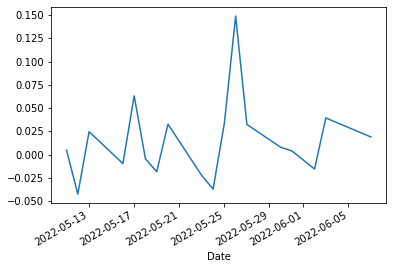

In [45]:
#3
monthly_rtn_graph('OCI')

In [47]:
#4
opinion('OCI')

1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
40/40


,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관
57,2022-06-02,OCI,010060,시황을 반영하지 못하고 있는 주가 시황을 반영하지 못하고 있는 주가 시황을 반영하...,"180,000",Buy,황성현,유진투자증권
130,2022-05-31,OCI,010060,태양광산업의주도주 태양광산업의주도주 러시아 지정학 Risk 발생 이후 태양광 산업...,"160,000",Buy,노우호,메리츠증권


In [48]:
#5
reply_vol('OCI')

2.2666666666666666